# 1.处理 并 生成FACE数据
gen_12net_data.py,根目录下执行
### 输入:
	DATA/WIDER_train/images:人脸图片
	DATA/WIDER_train/wider_face_train.txt:标注文件,格式:
		impath,[x1,y1,x2,y2]+ //表示一图多张人脸
### 输出:
	DATA/12/positive:包含人脸的图片
	DATA/12/negative:非人脸图片
	DATA/12/part:包含人脸,但是人脸比例不大不小
	DATA/12/pos_12.txt:  DATA/12/positive/0.jpg 1    0.09 -0.19 0.02 -0.05
	DATA/12/neg_12.txt:  DATA/12/negative/0.jpg 0                 //备注:非人脸没必要输出坐标.
	DATA/12/part_12.txt:    DATA/12/part/0.jpg -1    -0.22 -0.28 -0.10 0.08

#### 备注:图片左上角(0,0),右下角(1,1),W=1,H=1,pos/part_12.txt 输出的格式是
	impath,(1/-1),regx1,regy1,regx2,regy2
	regx1,regy1是对左上角(0,0)的修正,regx2,regy2是对右下角(1,1)的修正.

	例如,1 0.09 -0.19 0.02 -0.05:表示存在人脸,人脸在(0.09,-0.19),(1.02,0.95)的box(修正(0,0),(1,1))内 
### 处理过程:
	每次读入条记录:
		1.生成50个负样本(非人脸),大小在 [12,min(w,h)/2]之间,与标注人脸 box IOU<0.3的保存为负样本,
		  更新DATA/12/neg_12.txt,DATA/12/negative.
		2.在标注人脸box左上角随机选取5个size 在 [12,min(w,h)/2]的区域,与标注box IOU<0.3,保存为负样本,
		  更新DATA/12/neg_12.txt,DATA/12/negative.
		3.在标注box附近(box的中心随机移动+-0.2w,+-h),随机选取20个 0.8min(w,h)<=size<=1.25max(w,h)的区域,
			3.1:如果选取的与标注的IOC>0.65,输出为正样本DATA/12/pos_12.txt,DATA/12/positive.
			3.2:如果选取的与标注的0.4<=IOC<=0.65,输出为part样本,更新DATA/12/part_12.txt,DATA/12/part.
### 总结:每读到一张图片,生成55个负例,20(正例+part例).

# 2.处理 并 生成五官数据
    gen_landmark_aug_12.py,根目录下执行:
### 输入:
	DATA/lfw_train/ LFW五官数据集
    DATA/lfw_train/trainImageList.txt,人脸的坐标和五官的 绝对 坐标
	格式:
	image1_path left,top,right,bottom,p1.x,p1.y,p2.x,p2.y,p3.x,p3.y,p4.x,p4.y,p5.x,p5.y
### 输出:
	DATA/12/train_PNet_landmark_aug:下面经过加强处理的LandMark图片.
	DATA/12/landmark_pnet_aug.txt:输出landmark的标注,格式如下:
		image1_path,-2,p1.x,p1.y,p2.x,p2.y,p3.x,p3.y,p4.x,p4.y,p5.x,p5.y
	备注:图片左上角(0,0),右下角(1,1),W=1,H=1,pi.x,pi,y是相对于左上角的坐标!.
### 处理过程:
	每次读入条记录:
		1.输出切割下的人脸到DATA/12/train_PNet_landmark_aug,五官记录到DATA/12/landmark_pnet_aug.txt.
		2.随机把刚才的人脸中心平移(+- 0.2W,+-0.2h),然后取0.8min(w,h)<=size<=1.25max(w,h)的区域,如果这个区域
		和原始的IOC>0.65,把这个区域以及五官(相对于这个区域坐标)分别输出train_PNet_landmark_aug,landmark_pnet_aug.txt,这个随机切割迭代10次.
			2.1:有0.5的概率水平反转2生成的图片,并把人脸,五官信息更新到train_PNet_landmark_aug,train_PNet_landmark_aug.txt.
			
            2.2:有0.5的概率旋转2生成的图片(0-+5C),并且反转生成的图片,更新train_PNet_landmark_aug,train_PNet_landmark_aug.txt
			
            2.3:有0.5的概率旋转2生成的图片(-5-0C),并且反转生成的图片,更新train_PNet_landmark_aug,train_PNet_landmark_aug.txt
### 总结:读到一张图片,大约生成 1+10*(1+0.5+0.5 * 2+0.5 * 2)=36张人脸.

# 3.合并人脸,五官训练数据
gen_imglist_pnet.py,根目录下执行
### 输入:
	DATA/12/pos_12.txt:  DATA/12/positive/0.jpg 1    0.09 -0.19 0.02 -0.05
	DATA/12/neg_12.txt:  DATA/12/negative/0.jpg 0                 //备注:非人脸没必要输出坐标.
	DATA/12/part_12.txt: DATA/12/part/0.jpg -1       -0.22 -0.28 -0.10 0.08
	DATA/12/landmark_pnet_aug.txt
### 输出:
	DATA/imglists/pnet/train_pnet_landmark.txt
### 处理过程:
    在pos,part,landmark数据集中,各选25W个例子,neg数据集中选75W例,按照pos,neg,part,landmark
    的顺序输出DATA/imglists/pnet/train_pnet_landmark.txt.
    
    1-----(+)
    0-----(-)
    -1----(part)
    -2----(landmark)
base_num = 250000
### 总结:生成150W个例子.+,landmark,part各占25W,- 占75W

# 4.生成训练数据TFRecord
gen_PNet_tfrecords.py
### 输入:
	DATA/imglists/pnet/train_pnet_landmark.txt
	DATA/12/positive:包含人脸的图片
	DATA/12/negative:非人脸图片
	DATA/12/part:包含人脸,但是人脸比例不大不小
### 输出:
	DATA/imglists/PNet/train_PNet_landmark.tfrecord_shuffle
### 处理过程:
	把一个numpy表示的属性,序列化后输出成为一条一条TF记录,一个记录表示一个EXAMPLE.
	一个example 4个属性:
		image/encoded: bytes数组 类型,表示图像
		image/label  :int64数组[1],表示数据类型(+,-,landmark,part)
		image/roi    :float 数组[4],表示人脸box
		image/landmark:float 数组[10],表示五官
### 学习:tf.train.Features,tf.train.Feature,tf.train.Example,tf.is.TFRecordWriter的使用.

## 5.训练Pnet
    train_models/train_PNet.py
    
 ### 输入:
     DATA/imglists/PNet/train_PNet_landmark.tfrecord_shuffle
     DATA/imglists/pnet/train_pnet_landmark.txt
 ### 输出:
     data/MTCNN_model/PNet_landmark/PNet 下生成PNet的训练模型
 ### 训练过程:
     对class_loss,bbox_loss,landmark_loss,regular_loss进行训练
         total_loss=class_loss+0.5*bbox_loss+0.5*landmark_loss+regular_loss
     class_loss:70%的正负样本的参与计算.
     bbox_loss:正,part样本参与计算
     landmark_loss:label=-2的样本参与计算
 ### 训练参数:
     BATCH_SIZE:384
     EPOCHS:30
     baselr:1e-4
     lr_decay:0.9,在6,14,20epoch后,lr=lr_before*0.9
     optimizer:momentum(0.9)

## 6.生成Rnet的Hard Example
### 输入:
    DATA/WIDER_train/wider_face_train_bbx_gt.txt //wider数据集的标注文件
### 输出:
    DATA/no_LM24/positive: Pnet判断正确的正样本,Pnet输出区域与标注IOU>0.65
    DATA/no_LM24/negative::Pnet选出来的-样本,Pnet输出区域与标注IOU<0.3
    DATA/no_LM24/part: ,Pnet输出区域与标注IOU 在[0.4,0.65] 之间
    DATA/no_LM24/RNet/detections.pkl: Pnet对wider数据集检测后的结果保存在detections.pkl,detections是一个list,
    长度与wider数据集图片数量相等,每一个元素list[i]是一个numay array,shape[N',4],表示pnet认为,image[i]中存在N'张人脸,
    分别记录相对于原图人脸定位的坐标(x1,y1,x2,y2),I[i][y1:y2,x1:x2]是一张pnet认为的人脸!
    
    //和标注比较后,得出hardexmaple的标注,注意offsetx1,offsety1,offsetx2,offsety2与上面4个点的区别,这里是相对人脸区域的修正,
    //而不是人脸在原图的坐标!
    DATA/no_LM24/pos_24.txt: 格式-> imgaepath 1 offsetx1,offsety1,offsetx2,offsety2
    DATA/no_LM24/neg_24.txt: 格式-> imgaepath 0
    DATA/no_LM24/part_24.txt:格式-> imgaepath -1 offsetx1,offsety1,offsetx2,offsety2
### 处理过程:
    对于每一张图片,初始缩放比例是I1=(H,W)/min*12,然后在这个比例上面每次缩放0.79,直到图片的尺寸小于12x12位置:
        备注:PNET是一个可以检测12X12的人脸,第一次用Pnet检测>min大小的人脸,然后检测>min/0.79的,然后min/0.79/0.79,
    PNET对于<0.3的区域丢弃,对保留下来的做NMS
    汇集完成所有轮的人脸,在做一次NMS
    备注:
        
        第一次NMS:iou>0.5的被淘汰
        第二次NMS:iou>0.7的被淘汰
        thresold:0.3,小于0.3的淘汰
        scaleImageFactor:0.79

### 执行命令:
    python3 prepare_data/gen_hard_example.py
    --test_mode PNet 
    --prefix data/MTCNN_model/PNet_landmark/PNet data/MTCNN_model/RNet_No_Landmark/RNet data/MTCNN_model/ONet_No_Landmark/ONet

## 7.生成RNet网络的五官训练数据
    gen_landmark_aug_24.py,根目录下执行:
### 输入:
	DATA/lfw_train/ LFW五官数据集
    DATA/lfw_train/trainImageList.txt,人脸的坐标和五官的 绝对 坐标
	格式:
	image1_path left,top,right,bottom,p1.x,p1.y,p2.x,p2.y,p3.x,p3.y,p4.x,p4.y,p5.x,p5.y
### 输出:
	DATA/24/train_RNet_landmark_aug:下面经过加强处理的LandMark图片.
	DATA/24/landmark_Rnet_aug.txt:输出landmark的标注,格式如下:
		image1_path,-2,p1.x,p1.y,p2.x,p2.y,p3.x,p3.y,p4.x,p4.y,p5.x,p5.y
	备注:图片左上角(0,0),右下角(1,1),W=1,H=1,pi.x,pi,y是相对于左上角的坐标!.
### 处理过程:
    每次读入条记录:
        1.把标注的人脸,五官数据(转化相对人脸) 保存样本
        2.随机平移中心[-0.2,0.2],size[0.8min,1.25max],重复10次,
            所选区域与标注区域 IOU>0.65,认做一个样本
                A)0.5的概率 镜像,并保存
                B)0.5的概率,正向选择,然后镜像
                C)0.5的概率,逆向向选择,然后镜像
        3.把选出的图片,标注 分别 输出到DATA/24/train_RNet_landmark_aug,DATA/24/landmark_Rnet_aug.txt
          备注:如果五官在图片外,landmark<0 or landmark>1,视为无效的,不会输出
    总输出:读取一张,输出 1+10(1+0.5+0.5*2+0.5*2)=36张

## 8.合并Rnet的人脸,五官标注数据

### 输入:
    //人脸标注
    DATA/no_LM24/pos_24.txt: 格式-> imgaepath 1 offsetx1,offsety1,offsetx2,offsety2
    DATA/no_LM24/neg_24.txt: 格式-> imgaepath 0
    DATA/no_LM24/part_24.txt:格式-> imgaepath -1 offsetx1,offsety1,offsetx2,offsety2
    //五官标注
    DATA/24/landmark_Rnet_aug.txt
### 输出:   
    DATA/imglists_noLM/RNet/train_RNet_landmark.txt

## 9.Rnet的 TFRecord 

### 输出:
    DATA/imglists_noLM/RNet/pos_landmark.tfrecord_shuffle
    DATA/imglists_noLM/RNet/neg_landmark.tfrecord_shuffle
    DATA/imglists_noLM/RNet/part_landmark.tfrecord_shuffle
    DATA/imglists_noLM/RNet/landmark_landmark.tfrecord_shuffle

### 10.训练Rnet
    train_models/train_RNet.py
### 输入:
    DATA/imglists_noLM/RNet/pos_landmark.tfrecord_shuffle
    DATA/imglists_noLM/RNet/neg_landmark.tfrecord_shuffle
    DATA/imglists_noLM/RNet/part_landmark.tfrecord_shuffle
    DATA/imglists_noLM/RNet/landmark_landmark.tfrecord_shuffle
    DATA/imglists_noLM/RNet/train_RNet_landmark.txt  //不用于训练,只用于计算有多少样本数量
### 输出:
    data/MTCNN_model/RNet_No_Landmark/RNet/  //训练好的RNet模型
    logs/RNet   //训练日志

In [1]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

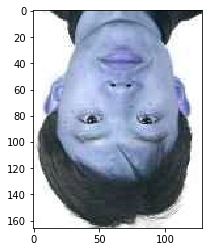

In [5]:
img=cv2.imread('/home/zhangxk/mysite/webapp/facedb1/1.png')
cv2.flip(img,0,img)
plt.imshow(img)

In [1]:
prefix=['../data/MTCNN_model/PNet_No_Landmark/PNet', '../data/MTCNN_model/RNet_No_Landmark/RNet', '../data/MTCNN_model/ONet_No_Landmark/ONet']
epoch=[18,14,16]
model_path = ['%s-%s' % (x, y) for x, y in zip(prefix, epoch)]

In [3]:
model_path=model_path[0]

In [4]:
model_path

'../data/MTCNN_model/PNet_No_Landmark/PNet-18'

In [5]:
 '/'.join(model_path.split('/')[:-1])

'../data/MTCNN_model/PNet_No_Landmark'